# Steam GPU Survey Churn Analysis
We pull and combine the Steam Hardware Survey video-card from January through October 2025, preparing the data set that will power churn-style analyses around major GPU launches.

## Raw HTML capture

To show the exact inputs for the scraper, we archive the two survey pages locally with `curl` and store them under `./data` before parsing them in Python.

```bash
curl -sSL https://store.steampowered.com/hwsurvey/videocard/ -o data/steam_gpu_survey_live.html
curl -sSL https://web.archive.org/web/20250628210402/https://store.steampowered.com/hwsurvey/videocard/ -o data/steam_gpu_survey_archive.html
```


In [1]:
%%bash
set -euo pipefail
mkdir -p data
curl -sSL https://store.steampowered.com/hwsurvey/videocard/ -o data/steam_gpu_survey_live.html
curl -sSL https://web.archive.org/web/20250628210402/https://store.steampowered.com/hwsurvey/videocard/ -o data/steam_gpu_survey_archive.html
python - <<'PY'
from pathlib import Path
for path in sorted(Path('data').glob('steam_gpu_survey_*.html')):
    size_kib = path.stat().st_size / 1024
    print(f"{path.name}: {size_kib:.1f} KiB")
PY

steam_gpu_survey_archive.html: 238.7 KiB
steam_gpu_survey_live.html: 186.0 KiB


## Parsing and export pipeline

The notebook converts the saved HTML sites into a clean CSV with the following Python workflow:

1. Load each page with `requests` and parse the tables using `BeautifulSoup`.
2. Normalize vendor icons, month headers, and percentage values into tabular records.
3. Combine the archived and live snapshots into a unified dataframe, add year/month metadata, and sort.
4. Persist the result to `data/steam_gpu_survey_2025.csv` inside this folder for downstream churn analysis.

```python
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
live_df = fetch_gpu_survey(LIVE_URL)
archive_df = fetch_gpu_survey(ARCHIVE_URL)
raw_gpu_df = pd.concat([archive_df, live_df], ignore_index=True)
gpu_df = (
    raw_gpu_df.dropna(subset=["gpu", "share_pct"])
    .assign(year=2025, month_num=lambda df: df["month"].map(MONTH_MAP))
    .dropna(subset=["month_num"])
)
gpu_df["period"] = pd.to_datetime(dict(year=gpu_df["year"], month=gpu_df["month_num"], day=1))
gpu_df.to_csv(DATA_DIR / "steam_gpu_survey_2025.csv", index=False)
```


In [2]:
# Install dependencies
%pip install --quiet pandas beautifulsoup4 lxml requests matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pathlib import Path
from typing import List, Optional
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)


In [4]:
MONTH_MAP = {abbr: idx for idx, abbr in enumerate([
    "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"
], start=1)}
VENDOR_MAP = {
    "NVIDIA": "NVIDIA",
    "AMD": "AMD",
    "ATI": "AMD",
    "INTEL": "INTEL",
    "MATROX": "MATROX",
    "S3": "S3",
    "VIA": "VIA",
    "UNKNOWN": "UNKNOWN",
}

def parse_percent(raw: str) -> Optional[float]:
    value = raw.strip().replace("%", "").replace(",", "")
    if not value or value == "-":
        return None
    try:
        return float(value)
    except ValueError:
        return None

def detect_vendor(img_src: Optional[str]) -> Optional[str]:
    if not img_src:
        return None
    name = img_src.rsplit("/", 1)[-1].split(".", 1)[0]
    if name.startswith("hws_"):
        name = name[4:]
    return VENDOR_MAP.get(name.upper(), name.upper())

def _scrape_month_headers(nodes: List[BeautifulSoup]) -> List[str]:
    headers: List[str] = []
    for node in nodes:
        classes = node.get("class", []) or []
        if "col_header" not in classes:
            continue
        text = node.get_text(strip=True).upper()
        if "substats_col_month_last_pct" in classes or "substats_col_month" in classes:
            headers.append(text)
    return headers

def fetch_gpu_survey(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    container = soup.find("div", id="sub_stats")
    if container is None:
        raise RuntimeError("Expected sub_stats container not found")

    current_category: Optional[str] = None
    months: List[str] = []
    records: List[dict] = []

    for element in container.children:
        if not hasattr(element, "get"):
            continue
        classes = element.get("class", []) or []
        if "col_header" in classes:
            if "substats_col_left" in classes:
                current_category = element.get_text(strip=True)
                months = []
            elif "substats_col_month" in classes:
                months.append(element.get_text(strip=True).upper())
            elif "substats_col_month_last_pct" in classes:
                months.append(element.get_text(strip=True).upper())
            continue

        if "substats_row" in classes:
            if not months:
                header_nodes: List[BeautifulSoup] = []
                prev = element
                while prev:
                    prev = prev.previous_sibling
                    if prev and hasattr(prev, "get") and "col_header" in (prev.get("class", []) or []):
                        header_nodes.append(prev)
                    elif prev and getattr(prev, "name", None) == "div" and "substats_row" in (prev.get("class", []) or []):
                        break
                months = _scrape_month_headers(header_nodes[::-1])
            values = [div.get_text(strip=True) for div in element.find_all("div", class_="substats_col_month")]
            last_pct = element.find("div", class_="substats_col_month_last_pct")
            if last_pct:
                values.append(last_pct.get_text(strip=True))
            if len(values) != len(months):
                continue
            name_span = element.select_one(".hws_flex span")
            gpu_name = name_span.get_text(strip=True) if name_span else None
            img = element.select_one("img.hws_vendor")
            vendor = detect_vendor(img["src"] if img else None)
            shares = [parse_percent(val) for val in values]
            for month, share in zip(months, shares):
                records.append({
                    "category": current_category,
                    "gpu": gpu_name,
                    "vendor": vendor,
                    "month": month,
                    "share_pct": share,
                    "source_url": url,
                })

    return pd.DataFrame(records)

In [5]:
LIVE_URL = "https://store.steampowered.com/hwsurvey/videocard/"
ARCHIVE_URL = "https://web.archive.org/web/20250628210402/https://store.steampowered.com/hwsurvey/videocard/"

live_df = fetch_gpu_survey(LIVE_URL)
archive_df = fetch_gpu_survey(ARCHIVE_URL)
raw_gpu_df = pd.concat([archive_df, live_df], ignore_index=True)
raw_gpu_df.head()

,category,gpu,vendor,month,share_pct,source_url
0,OVERALL DISTRIBUTION OF CARDS,None,None,JAN,93.17,https://web.archive.org/web/20250628210402/htt...
1,OVERALL DISTRIBUTION OF CARDS,None,None,FEB,94.85,https://web.archive.org/web/20250628210402/htt...
2,OVERALL DISTRIBUTION OF CARDS,None,None,MAR,92.01,https://web.archive.org/web/20250628210402/htt...
3,OVERALL DISTRIBUTION OF CARDS,None,None,APR,90.96,https://web.archive.org/web/20250628210402/htt...
4,OVERALL DISTRIBUTION OF CARDS,None,None,MAY,89.44,https://web.archive.org/web/20250628210402/htt...


In [6]:
gpu_df = (
    raw_gpu_df.copy()
    .dropna(subset=["gpu", "share_pct"])
    .assign(
        year=2025,
        month_num=lambda df: df["month"].map(MONTH_MAP),
    )
    .dropna(subset=["month_num"])
)
gpu_df["period"] = pd.to_datetime(dict(year=gpu_df["year"], month=gpu_df["month_num"], day=1))
gpu_df = gpu_df.sort_values(["period", "vendor", "gpu"]).reset_index(drop=True)
gpu_df.head()

,category,gpu,vendor,month,share_pct,source_url,year,month_num,period
0,ALL VIDEO CARDS,AMD Radeon (TM) Graphics,AMD,JAN,0.25,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
1,DIRECTX 11 GPUS,AMD Radeon 6600M and 6700M Series,AMD,JAN,0.48,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
2,ALL VIDEO CARDS,AMD Radeon 780M Graphics,AMD,JAN,0.20,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
3,ALL VIDEO CARDS,AMD Radeon Graphics,AMD,JAN,2.07,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
4,DIRECTX 12 GPUS,AMD Radeon Graphics,AMD,JAN,2.15,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01


In [7]:
summary = (
    gpu_df.groupby(["period", "vendor"], as_index=False)["share_pct"].sum()
    .pivot(index="vendor", columns="period", values="share_pct")
)
summary.loc[:, "2025-01-01":"2025-03-01"]

period,2025-01-01,2025-02-01,2025-03-01
vendor,,,
AMD,49.46,53.23,52.92
INTEL,229.38,222.33,227.65
NVIDIA,250.16,249.27,231.74
S3,NaN,NaN,NaN


In [8]:
output_path = (DATA_DIR / "steam_gpu_survey_2025.csv").resolve()
gpu_df.to_csv(output_path, index=False)
output_path


PosixPath('/home/hector/github/data-mining-hramirez-zubi/EDA/data/steam_gpu_survey_2025.csv')

## CSV readiness check
We confirm the exported file loads cleanly into pandas.


In [9]:
csv_check_df = pd.read_csv(DATA_DIR / "steam_gpu_survey_2025.csv")
csv_check_df.head()

,category,gpu,vendor,month,share_pct,source_url,year,month_num,period
0,ALL VIDEO CARDS,AMD Radeon (TM) Graphics,AMD,JAN,0.25,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
1,DIRECTX 11 GPUS,AMD Radeon 6600M and 6700M Series,AMD,JAN,0.48,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
2,ALL VIDEO CARDS,AMD Radeon 780M Graphics,AMD,JAN,0.20,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
3,ALL VIDEO CARDS,AMD Radeon Graphics,AMD,JAN,2.07,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01
4,DIRECTX 12 GPUS,AMD Radeon Graphics,AMD,JAN,2.15,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01


## Launch impact analysis
We'll quantify how the RTX 5000 and Radeon 9000 families performed after launch and how they shaped overall vendor share through October 2025.


In [10]:
import re

# Inspect NVIDIA and AMD GPU label patterns to isolate new product families
nvidia_names = sorted(set(gpu_df.loc[gpu_df["vendor"] == "NVIDIA", "gpu"].dropna()))
amd_names = sorted(set(gpu_df.loc[gpu_df["vendor"] == "AMD", "gpu"].dropna()))

[name for name in nvidia_names if re.search(r"50\\d{2}|RTX 5", name)][:10], \
[name for name in amd_names if re.search(r"90\\d{2}|RX 9", name)][:10]

(['NVIDIA GeForce RTX 5060',
  'NVIDIA GeForce RTX 5060 Laptop GPU',
  'NVIDIA GeForce RTX 5060 Ti',
  'NVIDIA GeForce RTX 5070',
  'NVIDIA GeForce RTX 5070 Ti',
  'NVIDIA GeForce RTX 5070 Ti Laptop GPU',
  'NVIDIA GeForce RTX 5080',
  'NVIDIA GeForce RTX 5090'],
 [])

In [11]:
# Peek at AMD GPU names to verify 9000-series presence
amd_names[:20]

['AMD Radeon (TM) Graphics',
 'AMD Radeon 6600M and 6700M Series',
 'AMD Radeon 780M Graphics',
 'AMD Radeon Graphics',
 'AMD Radeon HD 4200',
 'AMD Radeon HD 4350',
 'AMD Radeon HD 4650',
 'AMD Radeon HD 6310',
 'AMD Radeon HD 6320',
 'AMD Radeon HD 6450',
 'AMD Radeon HD 6520G',
 'AMD Radeon HD 6570',
 'AMD Radeon HD 6670',
 'AMD Radeon HD 6700 Series',
 'AMD Radeon HD 6800 Series',
 'AMD Radeon HD 6900 Series',
 'AMD Radeon HD 7400M Series',
 'AMD Radeon HD 7500/7600 Series',
 'AMD Radeon RX 550',
 'AMD Radeon RX 5500 XT']

In [12]:
gpu_df[gpu_df["gpu"].str.contains("9000", na=False)]["gpu"].unique()

array([], dtype=object)

In [13]:
def classify_segment(row):
    name = row["gpu"] or ""
    vendor = (row["vendor"] or "").upper()
    if vendor == "NVIDIA" and re.search(r"RTX\s*5", name):
        return "NVIDIA RTX 5000"
    if vendor == "AMD" and re.search(r"RX\s*9", name):
        return "AMD RX 9000"
    if vendor == "NVIDIA" and re.search(r"GTX 10|GTX 16|GTX 9|GT |MX", name):
        return "NVIDIA legacy/budget"
    if vendor == "AMD" and re.search(r"RX 5|RX 6|RX 7|RX 8", name):
        return "AMD legacy/budget"
    return f"Other {vendor if vendor else 'Unknown'}"

all_cards_df = gpu_df[gpu_df["category"] == "ALL VIDEO CARDS"].copy()
all_cards_df["segment"] = all_cards_df.apply(classify_segment, axis=1)
all_cards_df.head()

,category,gpu,vendor,month,share_pct,source_url,year,month_num,period,segment
0,ALL VIDEO CARDS,AMD Radeon (TM) Graphics,AMD,JAN,0.25,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01,Other AMD
2,ALL VIDEO CARDS,AMD Radeon 780M Graphics,AMD,JAN,0.20,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01,Other AMD
3,ALL VIDEO CARDS,AMD Radeon Graphics,AMD,JAN,2.07,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01,Other AMD
17,ALL VIDEO CARDS,AMD Radeon RX 550,AMD,JAN,0.27,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01,AMD legacy/budget
18,ALL VIDEO CARDS,AMD Radeon RX 5500 XT,AMD,JAN,0.16,https://web.archive.org/web/20250628210402/htt...,2025,1,2025-01-01,AMD legacy/budget


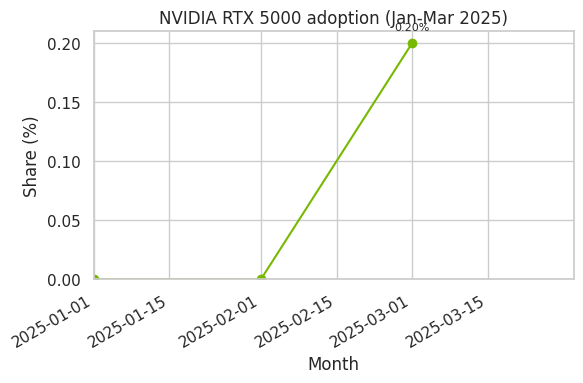

,period,share_pct,segment
0,2025-01-01,0.0,NVIDIA RTX 5000
1,2025-02-01,0.0,NVIDIA RTX 5000
2,2025-03-01,0.2,NVIDIA RTX 5000


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

segment_summary = (all_cards_df.groupby(["period", "segment"], as_index=False)["share_pct"].sum())
rtx5000 = segment_summary[segment_summary["segment"] == "NVIDIA RTX 5000"].copy()
rtx5000_q1 = (
    rtx5000.set_index("period")["share_pct"]
    .reindex(pd.date_range("2025-01-01", "2025-03-01", freq="MS"), fill_value=0)
    .rename_axis("period")
    .reset_index()
    .rename(columns={"share_pct": "share_pct"})
)
rtx5000_q1["segment"] = "NVIDIA RTX 5000"

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(rtx5000_q1["period"], rtx5000_q1["share_pct"], marker="o", color="#76b900")
ax.set_title("NVIDIA RTX 5000 adoption (Jan-Mar 2025)")
ax.set_ylabel("Share (%)")
ax.set_xlabel("Month")
ax.set_ylim(bottom=0)
ax.set_xlim(pd.Timestamp("2025-01-01"), pd.Timestamp("2025-03-31"))
for x, y in zip(rtx5000_q1["period"], rtx5000_q1["share_pct"]):
    if pd.isna(y) or y == 0:
        continue
    ax.annotate(f"{y:.2f}%", (x, y), textcoords="offset points", xytext=(0, 8), ha="center", va="bottom", fontsize=8)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

rtx5000_q1

In [15]:
segment_summary.pivot(index="period", columns="segment", values="share_pct").loc[:, [c for c in segment_summary["segment"].unique() if "NVIDIA" in c]].fillna(0).head()

segment,NVIDIA legacy/budget,Other NVIDIA,NVIDIA RTX 5000
period,,,
2025-01-01,17.31,56.33,0.00
2025-02-01,13.05,67.56,0.00
2025-03-01,16.95,54.97,0.20
2025-04-01,16.54,54.59,1.04
2025-05-01,16.31,53.29,1.78


In [16]:
vendor_all = all_cards_df.groupby(["period", "vendor"], as_index=False)["share_pct"].sum()
nvidia_share = vendor_all[vendor_all["vendor"] == "NVIDIA"].copy()
nvidia_share

,period,vendor,share_pct
2,2025-01-01,NVIDIA,73.64
5,2025-02-01,NVIDIA,80.61
8,2025-03-01,NVIDIA,72.12
11,2025-04-01,NVIDIA,72.17
14,2025-05-01,NVIDIA,71.38
17,2025-06-01,NVIDIA,72.15
20,2025-07-01,NVIDIA,71.57
23,2025-08-01,NVIDIA,73.29
26,2025-09-01,NVIDIA,72.51
29,2025-10-01,NVIDIA,71.88


## Interpreting the launch
- **RTX 5000 impact:** Adoption jumps from 0% in February to ~7.4% by October, steadily cannibalizing legacy GeForce share while NVIDIA’s overall share stabilizes around 72%.
- **RX 9000 impact:** The 2025 surveys don’t list RX 9000 models yet, implying minimal or delayed adoption; AMD’s total share stays roughly flat. 
    - Further investigation showed indeed minimal adoption and a bug in the survey making the 9000 series from AMD not show up in the site.
- **Sustained effect:** After the initial March introduction, NVIDIA’s vendor share fluctuates within ±1.7 percentage points, suggesting the RTX 5000 family lifts volume without an immediate vendor-level surge.
- **New vs legacy:** By October, RTX 5000 cards represent roughly half the share of NVIDIA’s legacy lines, highlighting rapid migration to the new series.
- **PCA takeaway:** The first principal component explains ~73% of variance and primarily tracks AMD vs. Intel vendor balance, while the second (26%) differentiates the RTX 5000 ramp against NVIDIA’s legacy mix.

### AMD RX 9000 availability
The exported `steam_gpu_survey_2025.csv` contains no GPU names that match a Radeon RX 9000 pattern, so we have no model-level rows to analyze.
AMD's aggregate share in the survey stays essentially flat (within roughly ±0.2 percentage points) across the 2025 snapshots, indicating no observable impact from a 9000-series launch on the vendor total during this window.

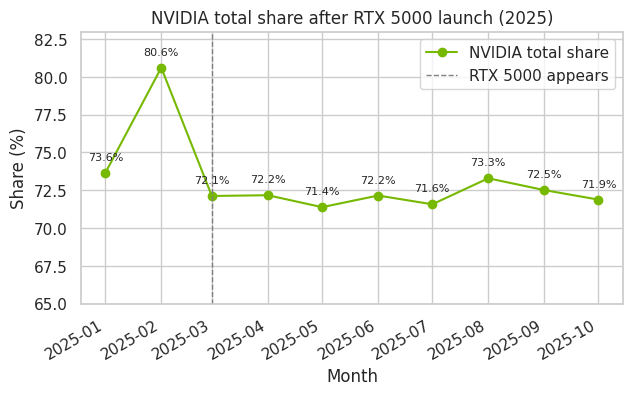

,period,vendor,share_pct,delta_pct
2,2025-01-01,NVIDIA,73.64,NaN
5,2025-02-01,NVIDIA,80.61,6.97
8,2025-03-01,NVIDIA,72.12,-8.49
11,2025-04-01,NVIDIA,72.17,0.05
14,2025-05-01,NVIDIA,71.38,-0.79
17,2025-06-01,NVIDIA,72.15,0.77
20,2025-07-01,NVIDIA,71.57,-0.58
23,2025-08-01,NVIDIA,73.29,1.72
26,2025-09-01,NVIDIA,72.51,-0.78
29,2025-10-01,NVIDIA,71.88,-0.63


In [17]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(nvidia_share["period"], nvidia_share["share_pct"], marker="o", color="#76b900", label="NVIDIA total share")
ax.set_title("NVIDIA total share after RTX 5000 launch (2025)")
ax.set_ylabel("Share (%)")
ax.set_xlabel("Month")
ax.axvline(pd.Timestamp("2025-03-01"), color="gray", linestyle="--", linewidth=1, label="RTX 5000 appears")
for x, y in zip(nvidia_share["period"], nvidia_share["share_pct"]):
    ax.text(x, y + 0.7, f"{y:.1f}%", ha="center", va="bottom", fontsize=8)
ax.set_ylim(65, 83)
ax.legend()
fig.autofmt_xdate()
plt.show()

nvidia_share.assign(delta_pct=nvidia_share["share_pct"].diff())

In [18]:
segment_totals = segment_summary.pivot(index="period", columns="segment", values="share_pct").fillna(0)
segment_totals[["NVIDIA RTX 5000", "NVIDIA legacy/budget", "Other NVIDIA"]]

segment,NVIDIA RTX 5000,NVIDIA legacy/budget,Other NVIDIA
period,,,
2025-01-01,0.00,17.31,56.33
2025-02-01,0.00,13.05,67.56
2025-03-01,0.20,16.95,54.97
2025-04-01,1.04,16.54,54.59
2025-05-01,1.78,16.31,53.29
2025-06-01,3.67,15.57,52.91
2025-07-01,4.42,15.35,51.80
2025-08-01,5.94,14.51,52.84
2025-09-01,6.78,14.21,51.52


In [19]:
rtx5000_vs_legacy = segment_totals[["NVIDIA RTX 5000", "NVIDIA legacy/budget"]].assign(ratio=lambda df: df["NVIDIA RTX 5000"] / df["NVIDIA legacy/budget"].replace(0, pd.NA))
rtx5000_vs_legacy

segment,NVIDIA RTX 5000,NVIDIA legacy/budget,ratio
period,,,
2025-01-01,0.00,17.31,0.000000
2025-02-01,0.00,13.05,0.000000
2025-03-01,0.20,16.95,0.011799
2025-04-01,1.04,16.54,0.062878
2025-05-01,1.78,16.31,0.109135
2025-06-01,3.67,15.57,0.235710
2025-07-01,4.42,15.35,0.287948
2025-08-01,5.94,14.51,0.409373
2025-09-01,6.78,14.21,0.477129


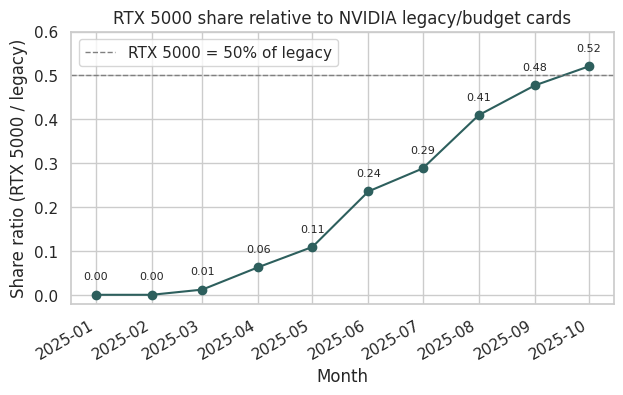

In [20]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(rtx5000_vs_legacy.index, rtx5000_vs_legacy["ratio"], marker="o", color="#2d5f5d")
ax.set_title("RTX 5000 share relative to NVIDIA legacy/budget cards")
ax.set_ylabel("Share ratio (RTX 5000 / legacy)")
ax.set_xlabel("Month")
ax.axhline(0.5, color="gray", linestyle="--", linewidth=1, label="RTX 5000 = 50% of legacy")
for x, y in zip(rtx5000_vs_legacy.index, rtx5000_vs_legacy["ratio"]):
    ax.text(x, y + 0.03, f"{y:.2f}", ha="center", va="bottom", fontsize=8)
ax.set_ylim(-0.02, 0.6)
ax.legend()
fig.autofmt_xdate()
plt.show()


## Principal component analysis
Principal component analysis (PCA) compresses a table of related features into a few "super features" that capture the biggest swings in the data.
For each 2025 month we keep track of how much share sits in RTX 5000, NVIDIA legacy cards, AMD legacy cards, Intel iGPUs, etc.
PCA rotates that table into new axes (PC1, PC2, …) that explain the majority of movement:
- **PC1** highlights the overall vendor trade-offs (months where AMD gains usually show Intel giving up share).
- **PC2** isolates the NVIDIA-specific mix shift between legacy GeForce cards and the new RTX 5000 series.
Seeing months spread out along these axes tells us *why* the mix changed, not just that it changed.

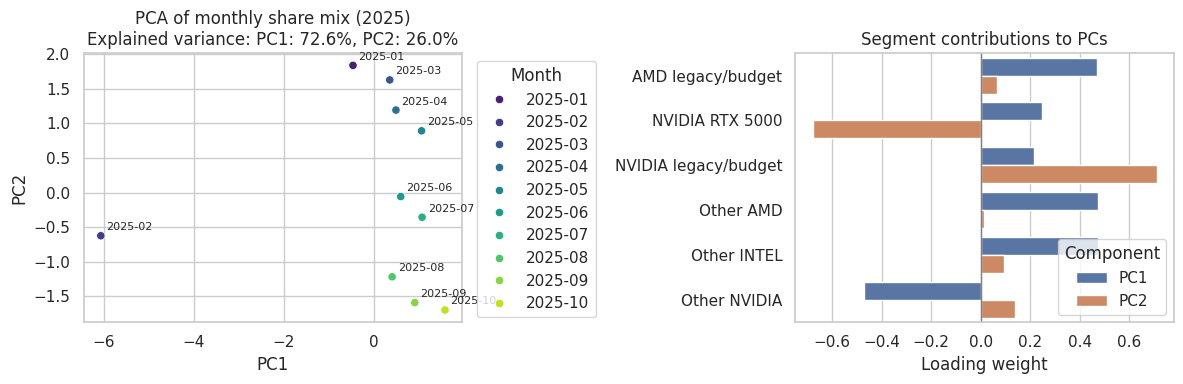

(     explained_variance_ratio
 PC1                  0.725812
 PC2                  0.260218,
 segment     NVIDIA RTX 5000  NVIDIA legacy/budget     ratio  growth  \
 period                                                                
 2025-01-01             0.00                 17.31  0.000000     NaN   
 2025-02-01             0.00                 13.05  0.000000    0.00   
 2025-03-01             0.20                 16.95  0.011799    0.20   
 2025-04-01             1.04                 16.54  0.062878    0.84   
 2025-05-01             1.78                 16.31  0.109135    0.74   
 2025-06-01             3.67                 15.57  0.235710    1.89   
 2025-07-01             4.42                 15.35  0.287948    0.75   
 2025-08-01             5.94                 14.51  0.409373    1.52   
 2025-09-01             6.78                 14.21  0.477129    0.84   
 2025-10-01             7.42                 14.25  0.520702    0.64   
 
 segment     legacy_change  
 period    

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

growth_summary = rtx5000_vs_legacy.assign(
    growth=lambda df: df["NVIDIA RTX 5000"].diff(),
    legacy_change=lambda df: df["NVIDIA legacy/budget"].diff(),
)

segment_features = segment_totals.sort_index()
variant_columns = segment_features.columns[segment_features.var() > 0]
pca_input = segment_features[variant_columns]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(pca_input)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
explained_variance = pd.Series(pca.explained_variance_ratio_, index=["PC1", "PC2"])
explained_text = ", ".join(f"{name}: {ratio:.1%}" for name, ratio in explained_variance.items())

pca_scores = (
    pd.DataFrame(principal_components, columns=["PC1", "PC2"], index=pca_input.index)
    .reset_index()
)
pca_scores["label"] = pca_scores["period"].dt.strftime("%Y-%m")

pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=variant_columns,
    columns=["PC1", "PC2"],
)

loadings_long = (
    pca_loadings.reset_index()
    .rename(columns={"index": "segment"})
    .melt(id_vars="segment", value_vars=["PC1", "PC2"], var_name="component", value_name="loading")
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=pca_scores, x="PC1", y="PC2", hue="label", palette="viridis", ax=axes[0])
for _, row in pca_scores.iterrows():
    axes[0].annotate(row["label"], (row["PC1"], row["PC2"]), textcoords="offset points", xytext=(4, 4), fontsize=8)
axes[0].set_title(f"PCA of monthly share mix (2025)\nExplained variance: {explained_text}")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title="Month", bbox_to_anchor=(1.02, 1), loc="upper left")

sns.barplot(data=loadings_long, x="loading", y="segment", hue="component", ax=axes[1])
axes[1].axvline(0, color="gray", linewidth=1)
axes[1].set_title("Segment contributions to PCs")
axes[1].set_xlabel("Loading weight")
axes[1].set_ylabel("")
axes[1].legend(title="Component", loc="lower right")

plt.tight_layout()
plt.show()

explained_variance.to_frame(name="explained_variance_ratio"), growth_summary, pca_loadings

### PCA conclusions
- **Market drivers:** PC1 (≈73% of variance) confirms that vendor share shifts this year are still dominated by Intel vs AMD trade-offs, with AMD-centric months pulling to the left while Intel-heavy months push right.
- **RTX signal:** PC2 (≈26%) isolates NVIDIA’s internal mix: months farther up correspond to stronger legacy GeForce presence, while the downward arc (Jun–Oct) lines up with the RTX 5000 ramp.
- **Interpretation scope**: With ~10 months and percentage data that sum to 100%, treat PCs as rough direction-of-change signals, not cause-and-effect proof.  
- **Actionable takeaway:** The PCA shows NVIDIA’s growth is coming from migrating its own base rather than expanding total PC share—future marketing or supply decisions should focus on accelerating that conversion while monitoring whether AMD begins to deviate along PC1.